In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from kan.utils import create_dataset
from adaptkan.jax.model import AdaptKANJax
from adaptkan.jax.viz import plot_model
from adaptkan.jax.fit import fit
from adaptkan.jax.data import DataLoader
from adaptkan.jax.losses import mse_loss_with_reg, mse_loss
import jax.numpy as jnp
import equinox as eqx
import jax
import jax.random as jr
import optax
import time
import matplotlib.pyplot as plt
import torch
import numpy as np
from jax import lax

In [3]:
# Uncomment to use cpu only
# import os
# os.environ["JAX_PLATFORM_NAME"] = "cpu"

### Generate our Data

In [4]:
# Generate data to train on
torch.set_default_dtype(torch.float64)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device="cpu", train_num=1000, ranges=[-1.,1.])
dataset['train_input'].shape, dataset['train_label'].shape

X_train = jnp.array(dataset['train_input'])
y_train = jnp.array(dataset['train_label'])
X_test = jnp.array(dataset['test_input'])
y_test = jnp.array(dataset['test_label'])

### Define our model

In [5]:
model, state = eqx.nn.make_with_state(AdaptKANJax)(width=[2,5,1],
                                                   num_grid_intervals=5, # Define the number of grid intervals for the splines
                                                   prune_patience=1, # Should be set to the number of batches per epoch. Influences when the network adapts
                                                   k=3, # Degree of the b-splines (Can be 1-5)
                                                   seed=0) # Random seed for reproducability

### Define a custom loss function

In [6]:
def basic_mse_loss(model, state, xs, ys, loss_args=None):
    # Forward pass to get predictions
    pred_ys, state = model(xs, state)
    
    # Compute loss
    loss = jnp.mean((pred_ys.squeeze() - ys.squeeze()) ** 2) # + sum(jnp.sum(jnp.square(param)) for param in jax.tree_util.tree_leaves(model)) * 0.00001
        
    # Return loss and a dictionary of metrics here, along with the state
    return loss, ({"loss": loss}, state)

### Training Step for AdaptKAN

In [7]:
@eqx.filter_jit
def make_step(model, state, loss_fn, opt_state, xs, ys):
    # NOTE: this is the only thing that needs to be added for the training compared to a regular MLP
    (loss, (metrics, state)), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model, state, xs, ys)

    # Adapting after the forward pass seems to work better
    if isinstance(model, AdaptKANJax):
        # Adapts the domain of the model if needed
        model, state, adapted = model.adapt(state)
        # Resets the optimizer state if we adapted the model
        # opt_state = lax.cond(adapted, lambda: optim.init(eqx.filter(model, eqx.is_array)), lambda: opt_state)
        
    updates, opt_state = optim.update(grads, opt_state, params=eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return model, state, opt_state, metrics

### Training Loop

In [9]:
# Define an optimizer
learning_rate = 1.0
optim = optax.adam(learning_rate)

# Initialize the optimizer state
opt_state = optim.init(eqx.filter(model, eqx.is_array))

start = time.time()
for step in range(2000):
    model, state, opt_state, metrics = make_step(model=model,
                                                  state=state,
                                                  opt_state=opt_state,
                                                  loss_fn=basic_mse_loss,
                                                  xs=X_train,
                                                  ys=y_train)
    if (step+1) % 100 == 0:
        print(f"Step {step + 1}, Loss: {metrics['loss'].item()}")
print(f"Took {time.time() - start} seconds.")

Step 100, Loss: 0.007698367349803448
Step 200, Loss: 0.0006687009008601308
Step 300, Loss: 0.0003544138162396848
Step 400, Loss: 0.021733276546001434
Step 500, Loss: 0.00020605974714271724
Step 600, Loss: 0.00015567413356620818
Step 700, Loss: 0.0010334007674828172
Step 800, Loss: 0.00011391340376576409
Step 900, Loss: 8.83934335433878e-05
Step 1000, Loss: 0.00257682497613132


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x78aa26ddceb0>>
Traceback (most recent call last):
  File "/home/jmoody/Projects/adaptkan/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

## Training with Pruning

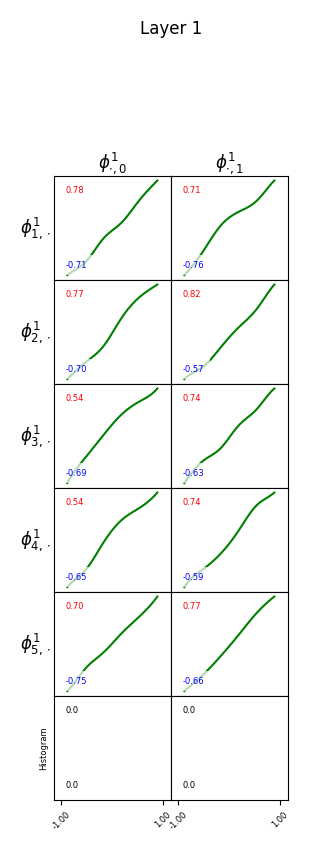

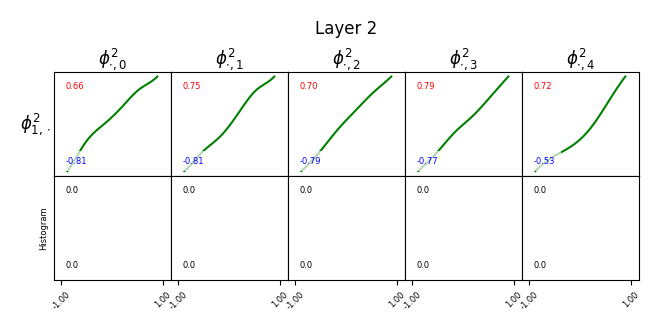

In [10]:
model, state = eqx.nn.make_with_state(AdaptKANJax)(width=[2,5,1],
                                                   num_grid_intervals=5, # Define the number of grid intervals for the splines
                                                   prune_patience=1, # Should be set to the number of batches per epoch. Influences when the network adapts
                                                   k=3, # Degree of the b-splines (Can be 1-5)
                                                   seed=0
                                                   ) # Random seed for reproducability

plot_model(model, state)

## Prune the model

 train_loss: 0.05663535 | test_loss: 0.05395218 |: 100%|███████| 1000/1000 [00:07<00:00, 140.32it/s]
 train_loss: 0.04310563 | test_loss: 0.03804560 |: 100%|███████| 1000/1000 [00:07<00:00, 137.34it/s]


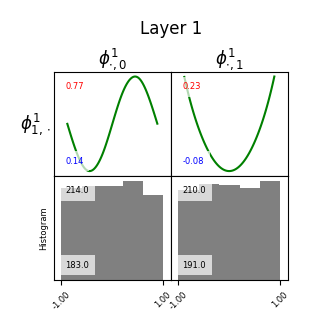

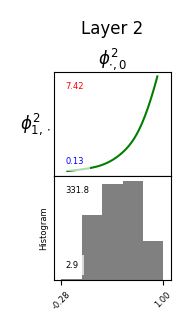

In [11]:
# Prune and train twice...
for _ in range(2):
    model, state, results = fit(model,
                                state,
                                train_data={"X": X_train, "y": y_train}, # the pre-defined MSE loss requires X and y keys
                                test_data={"X": X_test, "y": y_test},
                                learning_rate=0.1,
                                steps=1000,
                                loss_fn=mse_loss_with_reg,
                                opt="Adam",
                                # Pruning args
                                loss_args={"lamb": 0.01,
                                          "lamb_l1": 1.0,
                                          "lamb_entropy": 2.0})
    
    model, state = model.prune(X_train, state)
plot_model(model, state)

## Final training run

 train_loss: 0.00003647 | test_loss: 0.00003794 |: 100%|███████| 1000/1000 [00:07<00:00, 138.05it/s]


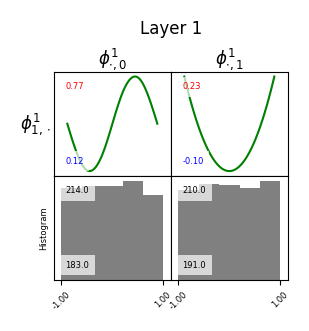

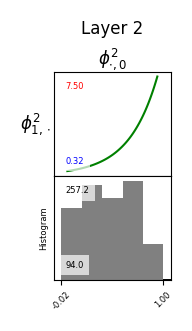

In [12]:
# Train one last time
model, state, results = fit(model,
                            state,
                            train_data={"X": X_train, "y": y_train}, # the pre-defined MSE loss requires X and y keys
                            test_data={"X": X_test, "y": y_test},
                            learning_rate=0.01,
                            steps=1000,
                            loss_fn=mse_loss,
                            opt="Adam")
plot_model(model, state)

### Compare with an MLP

In [13]:
model = eqx.nn.MLP(
                   in_size=2,                    # Input feature size
                   out_size=1,                   # Output feature size
                   width_size=100,               # Hidden layer width
                   depth=2,                      # Number of hidden layers
                   activation=jax.nn.tanh,       # Activation function
                   key=jax.random.PRNGKey(42)    # PRNG key for initialization
                  )
state = None # The MLP is stateless

# Fit expects a dataloader or a dictionary with 
model, state, results = fit(model,
                            state,
                            train_data={"X": X_train, "y": y_train}, # the pre-defined MSE loss requires X and y keys
                            test_data={"X": X_test, "y": y_test},
                            learning_rate=.01,
                            steps=3000,
                            opt="Adam")

 train_loss: 0.00044158 | test_loss: 0.00068401 |: 100%|███████| 3000/3000 [00:09<00:00, 318.07it/s]
